## Binary Classification with a Bank Dataset

[_Dataset Link_](https://www.kaggle.com/datasets/sushant097/bank-marketing-dataset-full)

_Your Goal: Your goal is to predict whether a client will subscribe to a bank term deposit_

#### This notebook builds strong baselines (Logistic Regression, XGBoost, LightGBM, CatBoost) with:

- Careful preprocessing (numeric + categorical)
- Stratified 5-Fold CV using ROC AUC
- Leakage guard (e.g., `duration`)
- Simple ensembling
- Ready-to-submit CSV


### Prepare Dependencies


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression

# Gradient Boosting
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

### Load Data


In [50]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

sub = pd.read_csv("sample_submission.csv")

print(train.shape, test.shape, sub.shape)
display(train.head())
display(test.head())

(750000, 18) (250000, 17) (250000, 2)


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
1,750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
2,750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
3,750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
4,750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown


#### Train DataFrame Inspection


In [53]:
display(train.head(10))
display(train.info())
display(train.isnull().sum())

display(train.describe(include=np.number))
display(train.describe(include='object'))

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1
5,5,24,admin.,single,secondary,no,1882,yes,no,cellular,20,apr,1010,3,-1,0,unknown,0
6,6,39,blue-collar,married,secondary,no,0,no,no,telephone,21,nov,90,1,-1,0,unknown,0
7,7,50,admin.,single,secondary,no,1595,no,no,telephone,31,jul,49,25,-1,0,unknown,0
8,8,46,blue-collar,married,primary,no,1463,no,no,cellular,4,aug,50,1,-1,0,unknown,0
9,9,39,management,divorced,tertiary,no,25,yes,no,cellular,8,may,119,1,-1,0,unknown,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


None

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

,id,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,216506.495284,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,0.000000,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,187499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,374999.500000,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,562499.250000,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,749999.000000,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


,job,marital,education,default,housing,loan,contact,month,poutcome
count,750000,750000,750000,750000,750000,750000,750000,750000,750000
unique,12,3,4,2,2,2,3,12,4
top,management,married,secondary,no,yes,no,cellular,may,unknown
freq,175541,480759,401683,737151,411288,645023,486655,228411,672450


_`Okay, There are no missings`_


In [12]:
train["y"].value_counts(normalize=True)

y
0    0.879349
1    0.120651
Name: proportion, dtype: float64

_`Amount of 0 labels is about 87% , But 1 Labels is about 13 %`_


(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

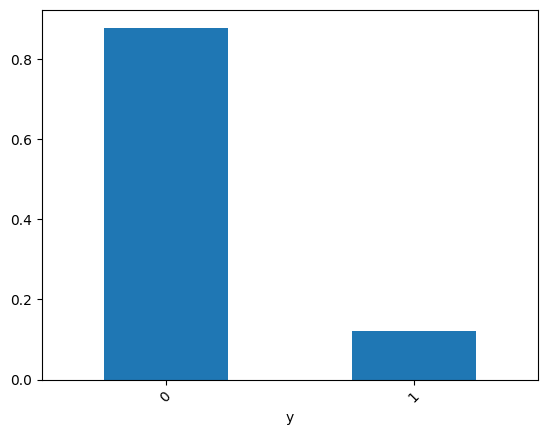

In [52]:
train["y"].value_counts(normalize=True).plot(kind='bar')
plt.xticks(rotation=45)

_`Unbalanced Data`_


_Features Relationship with Target_


<Axes: >

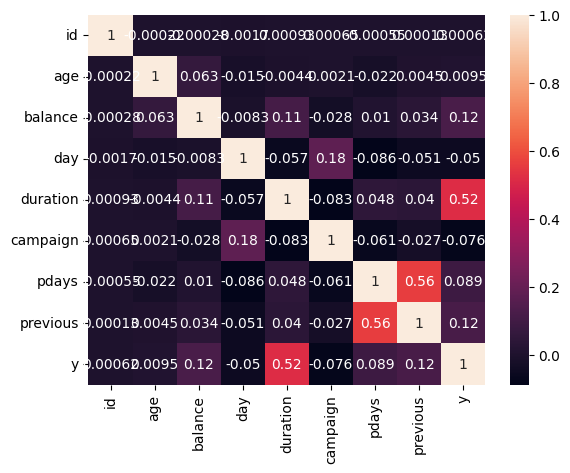

In [48]:
sns.heatmap(train.corr(method='pearson', numeric_only=True), annot=True)

### Split X/y


In [54]:
X = train.drop(columns=["y"], axis=1)
y = train["y"]

X_test = test.copy()

### Detect Columns Types


In [55]:
num_cols = X.select_dtypes(include=[np.number]).columns.to_list()
cat_cols = X.select_dtypes(include=["object"]).columns.to_list()

print(f"Numerical Columns\n{num_cols}")
print(f"Categorical Columns\n{cat_cols}")

Numerical Columns
['id', 'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical Columns
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


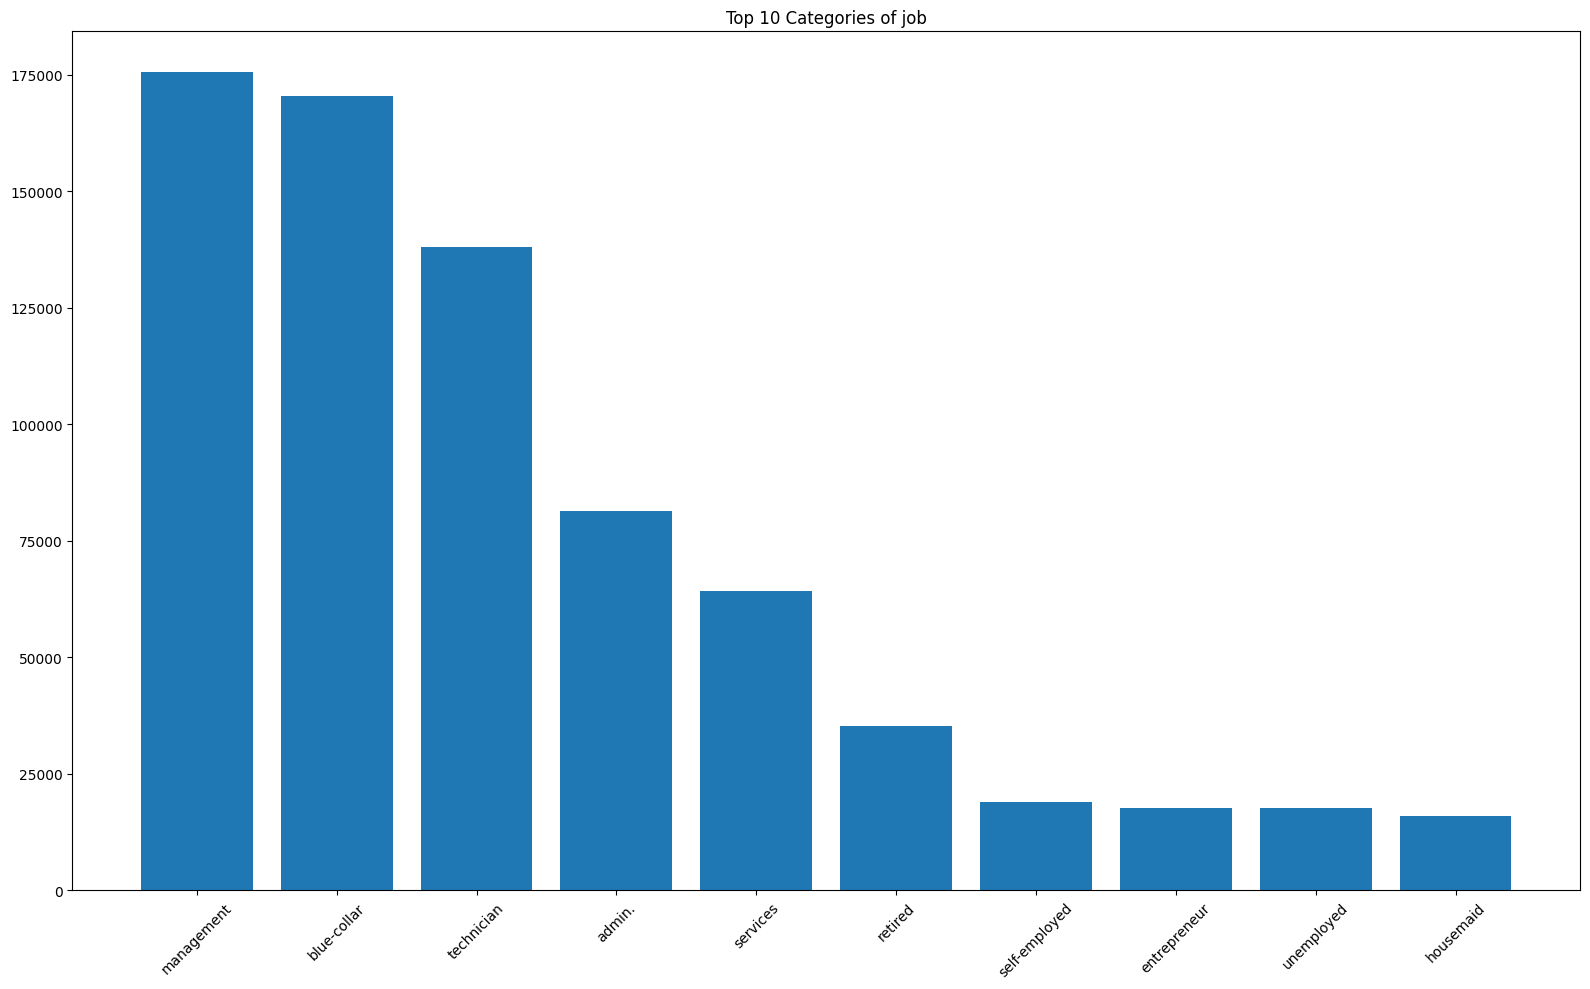

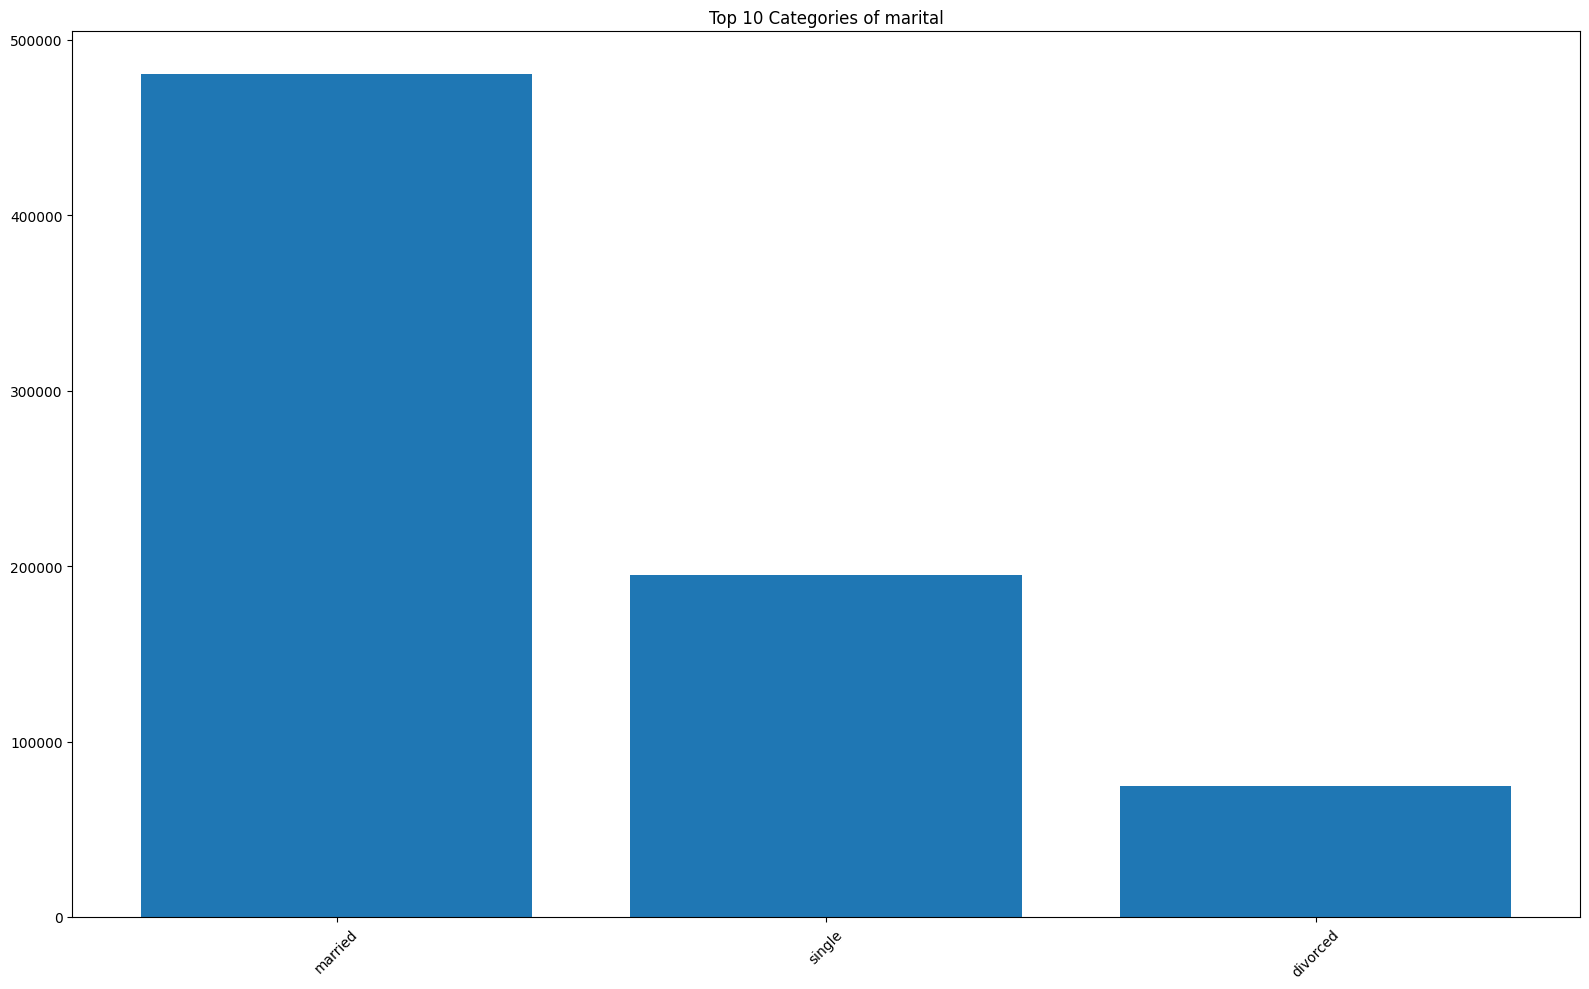

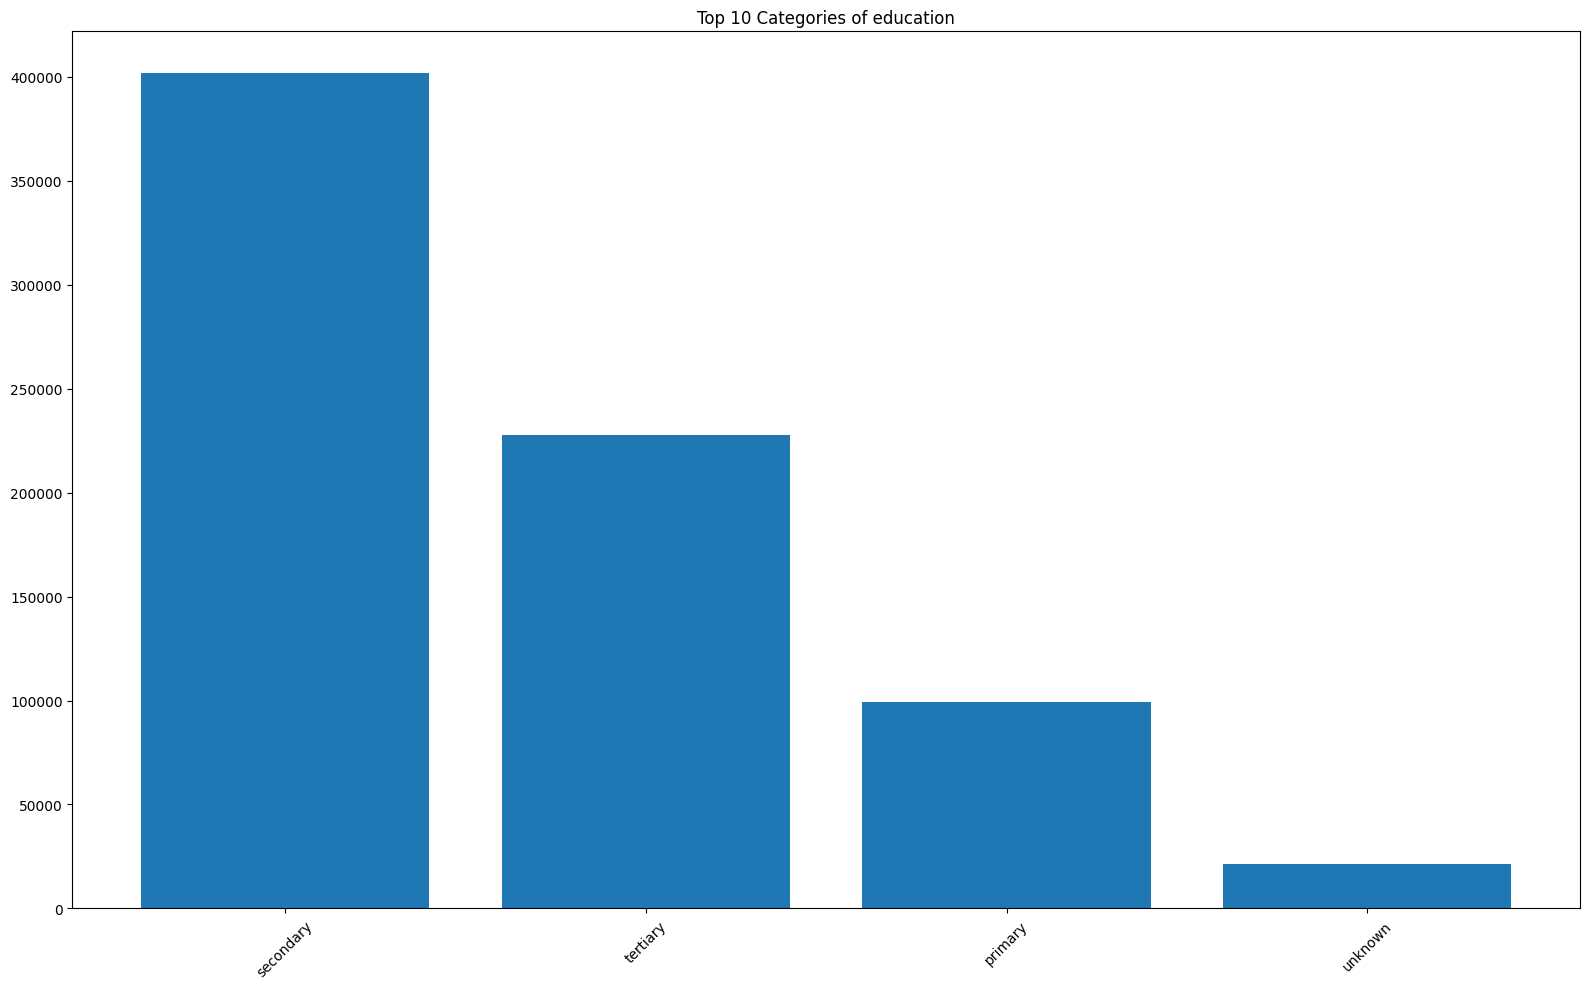

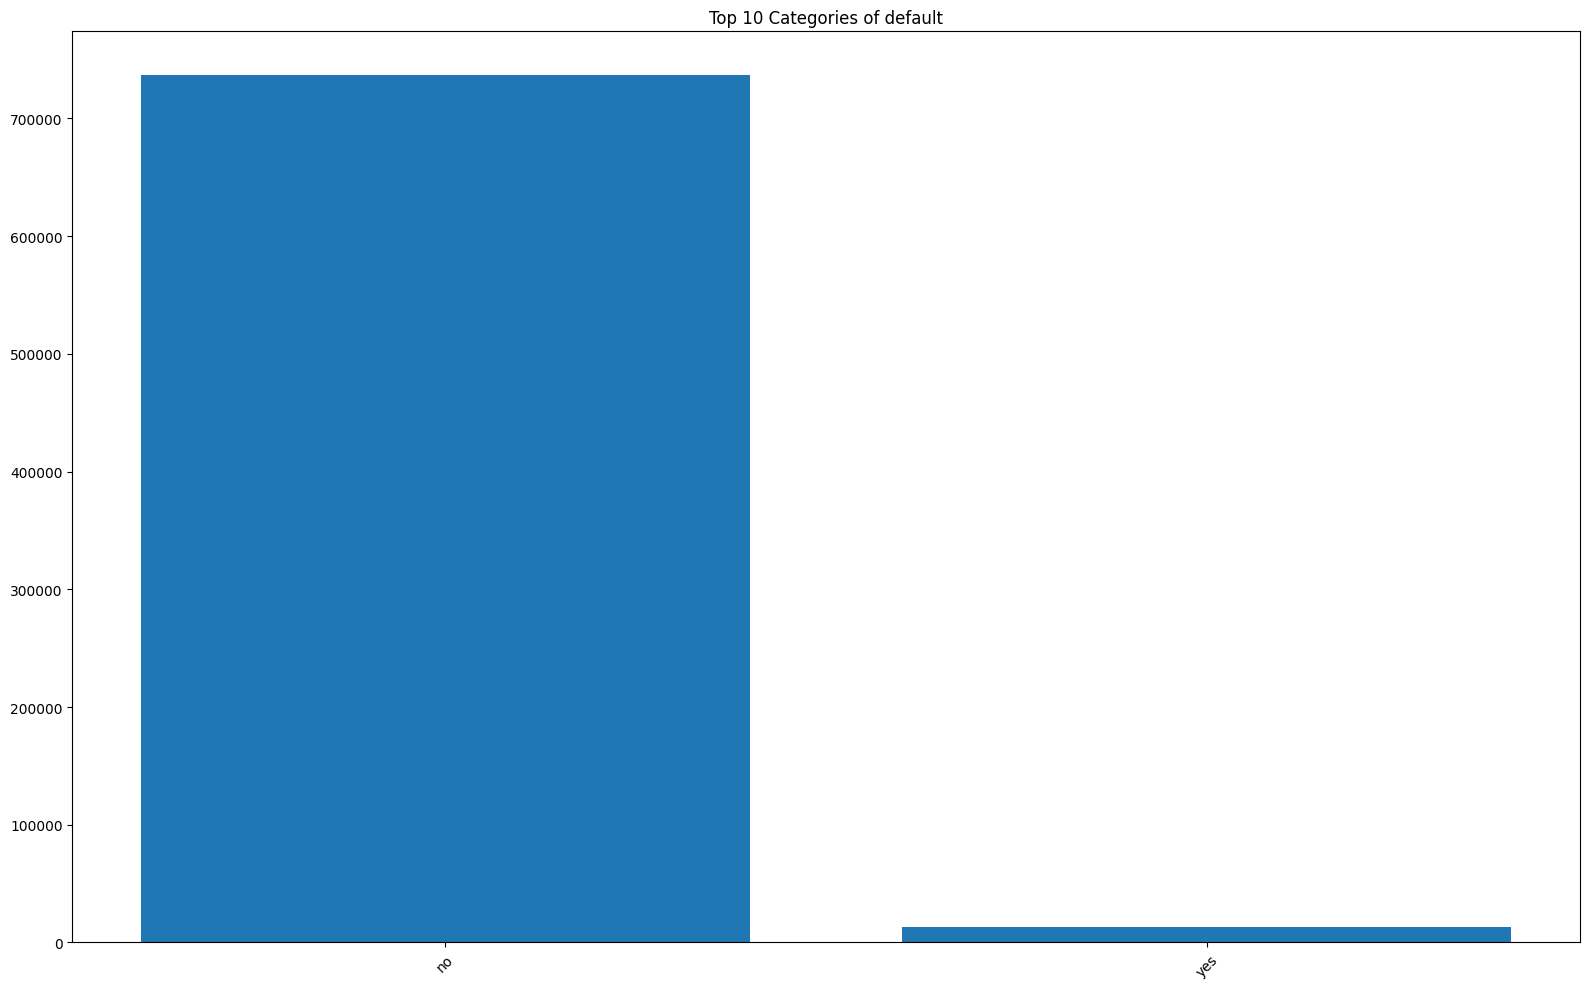

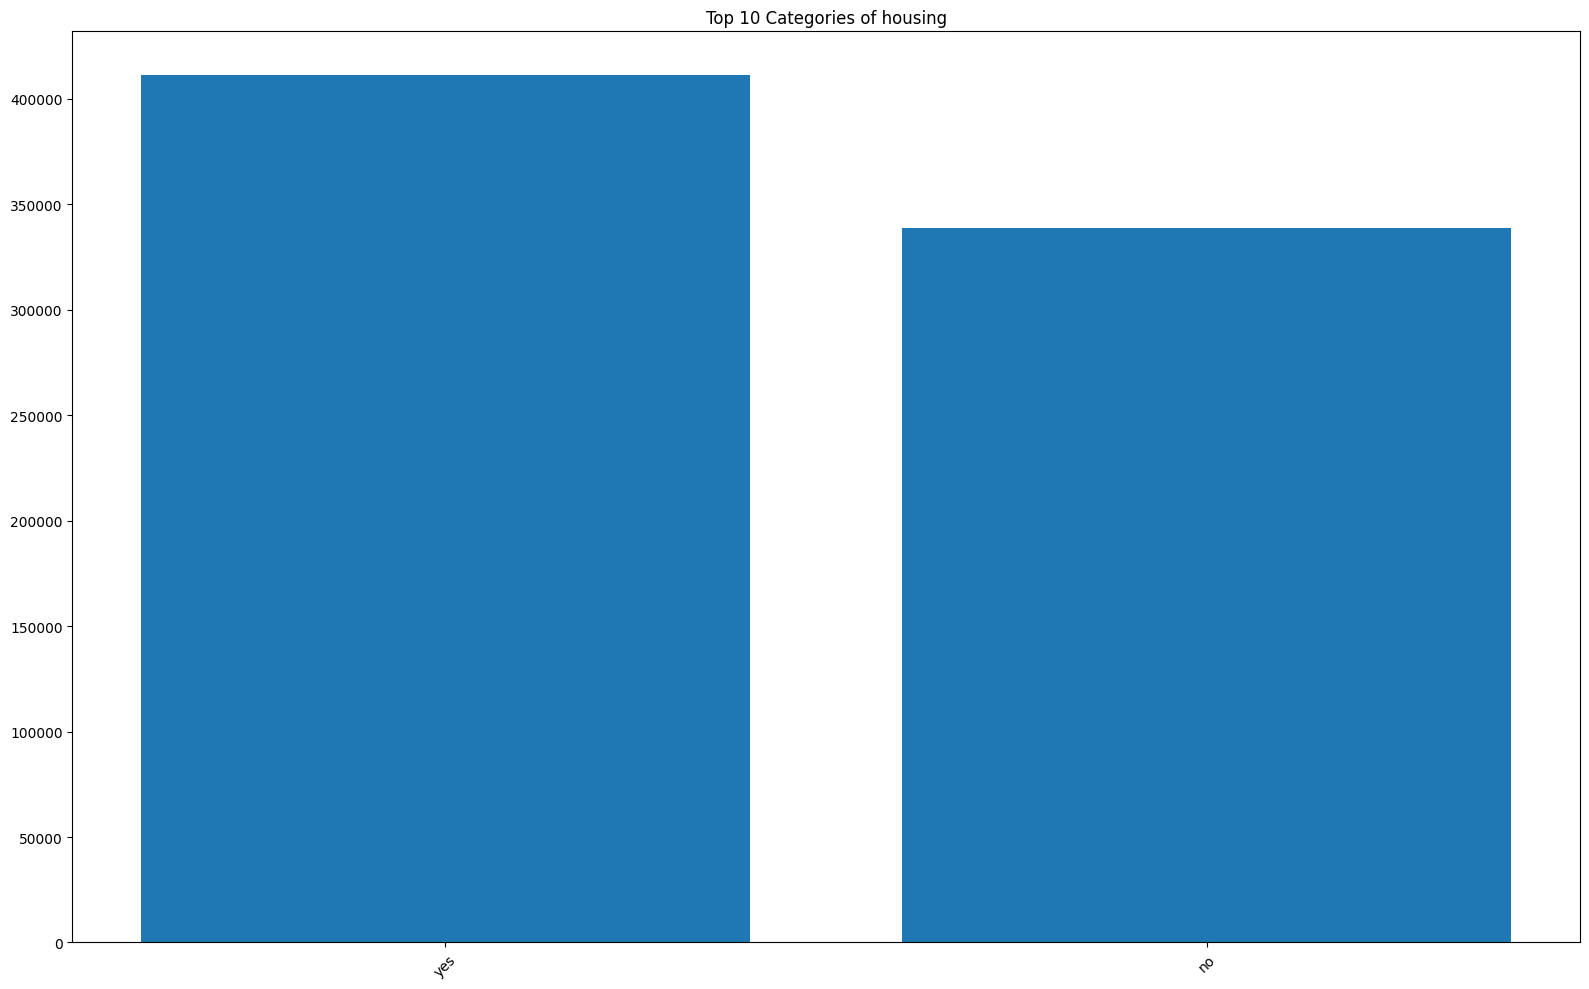

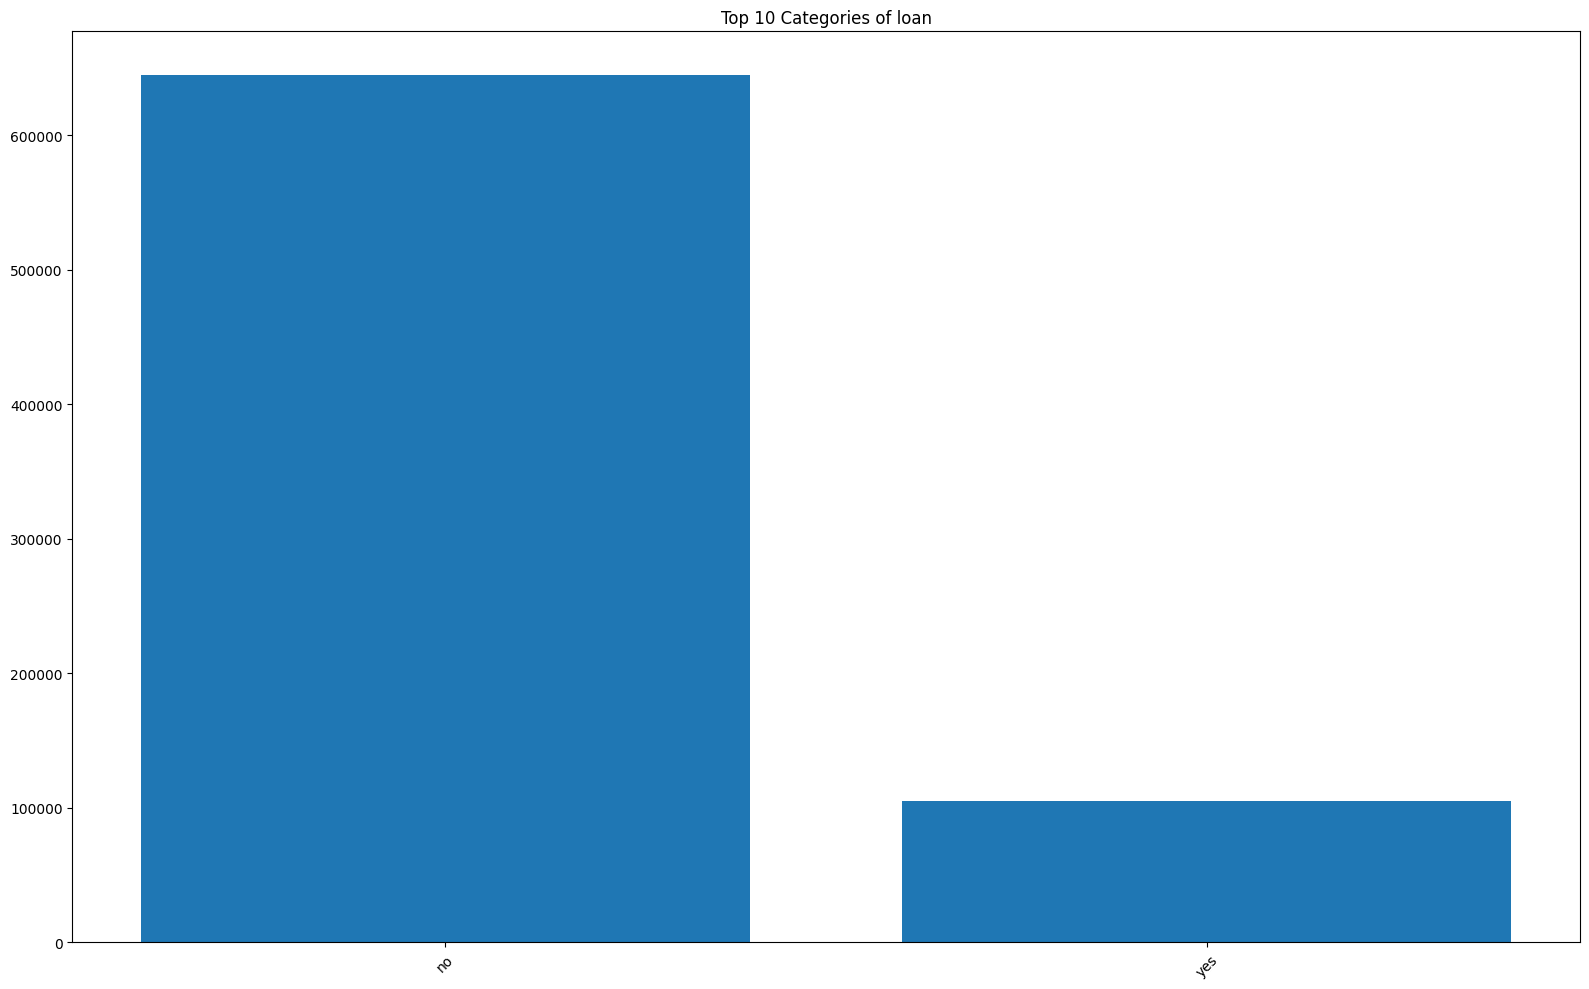

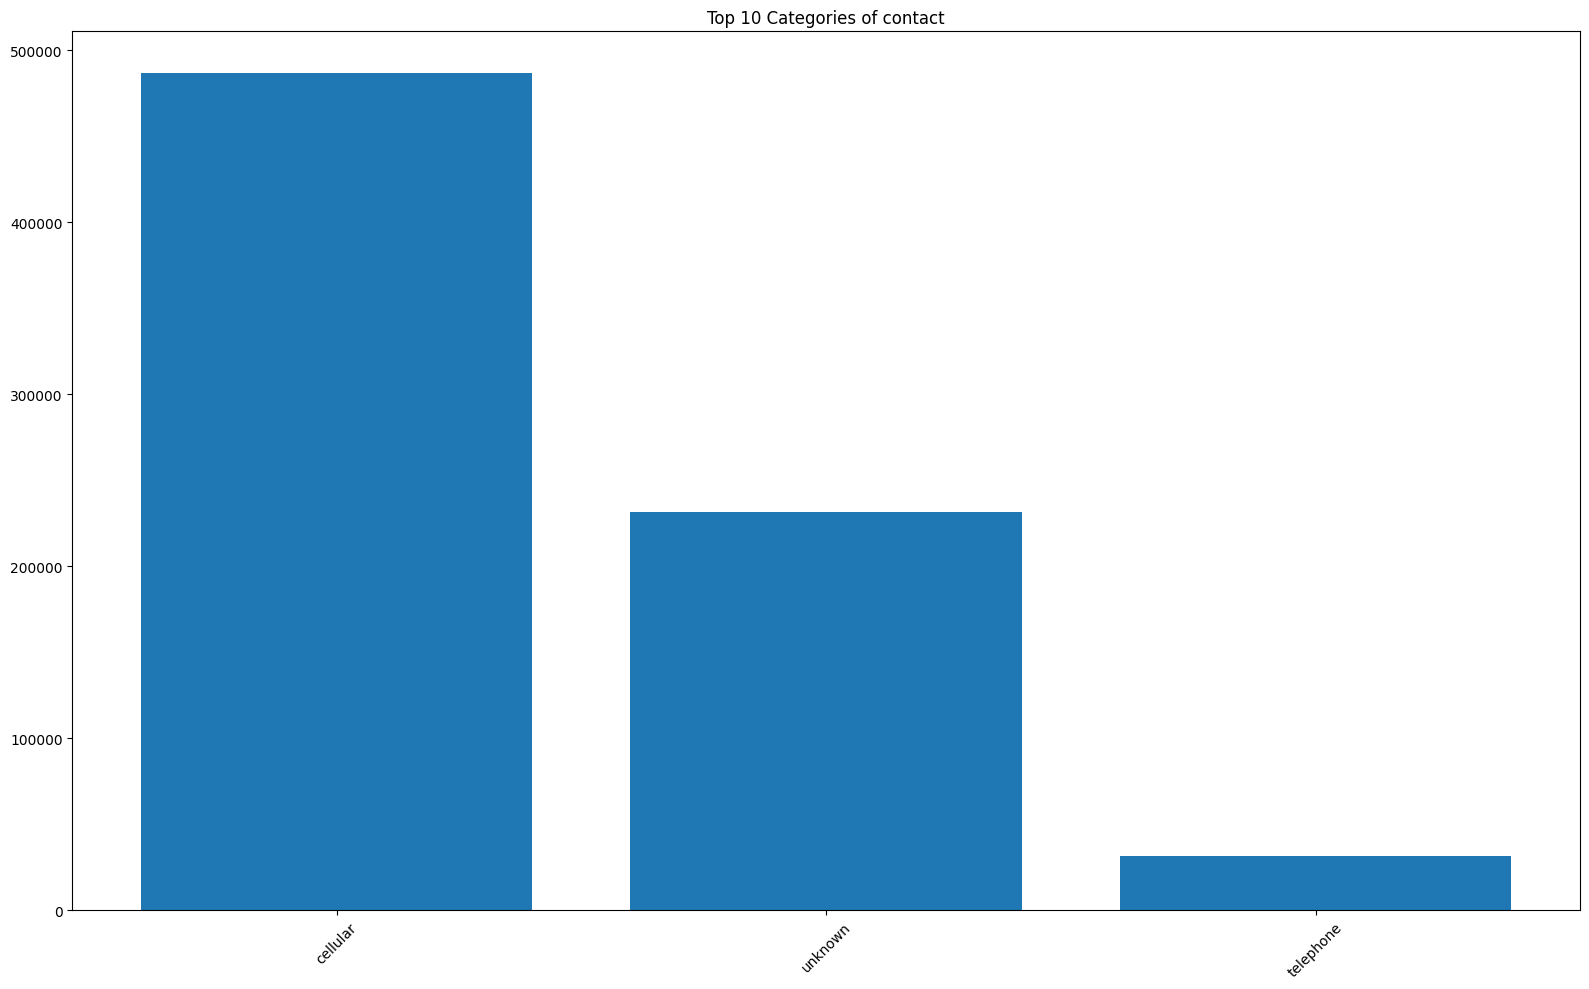

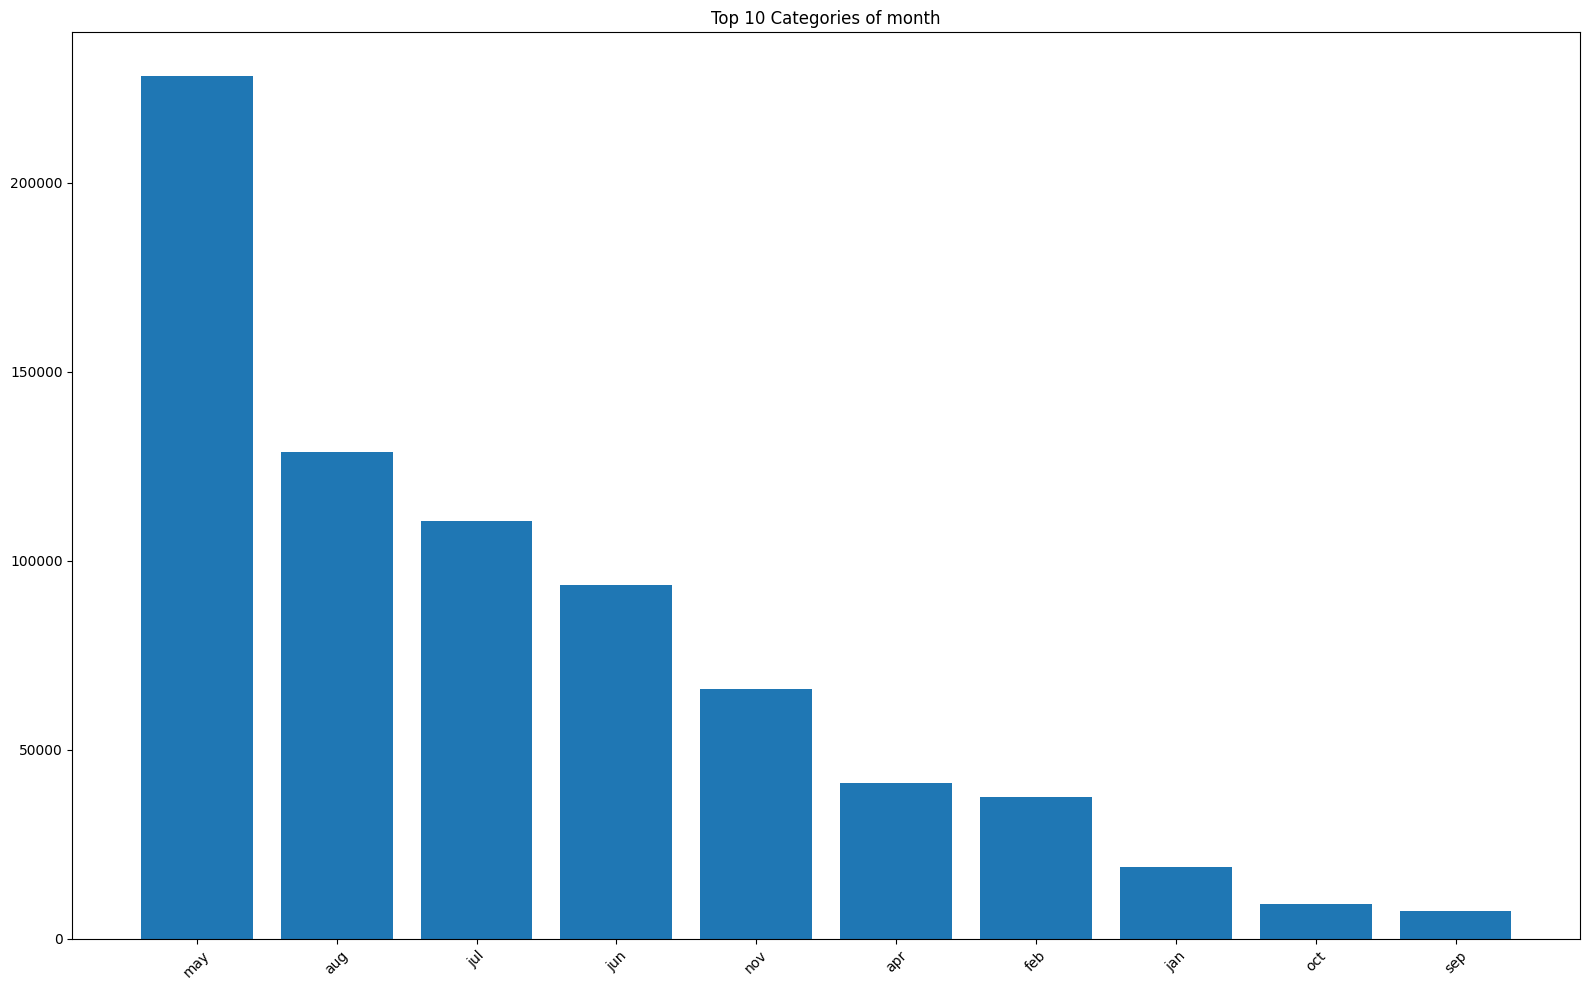

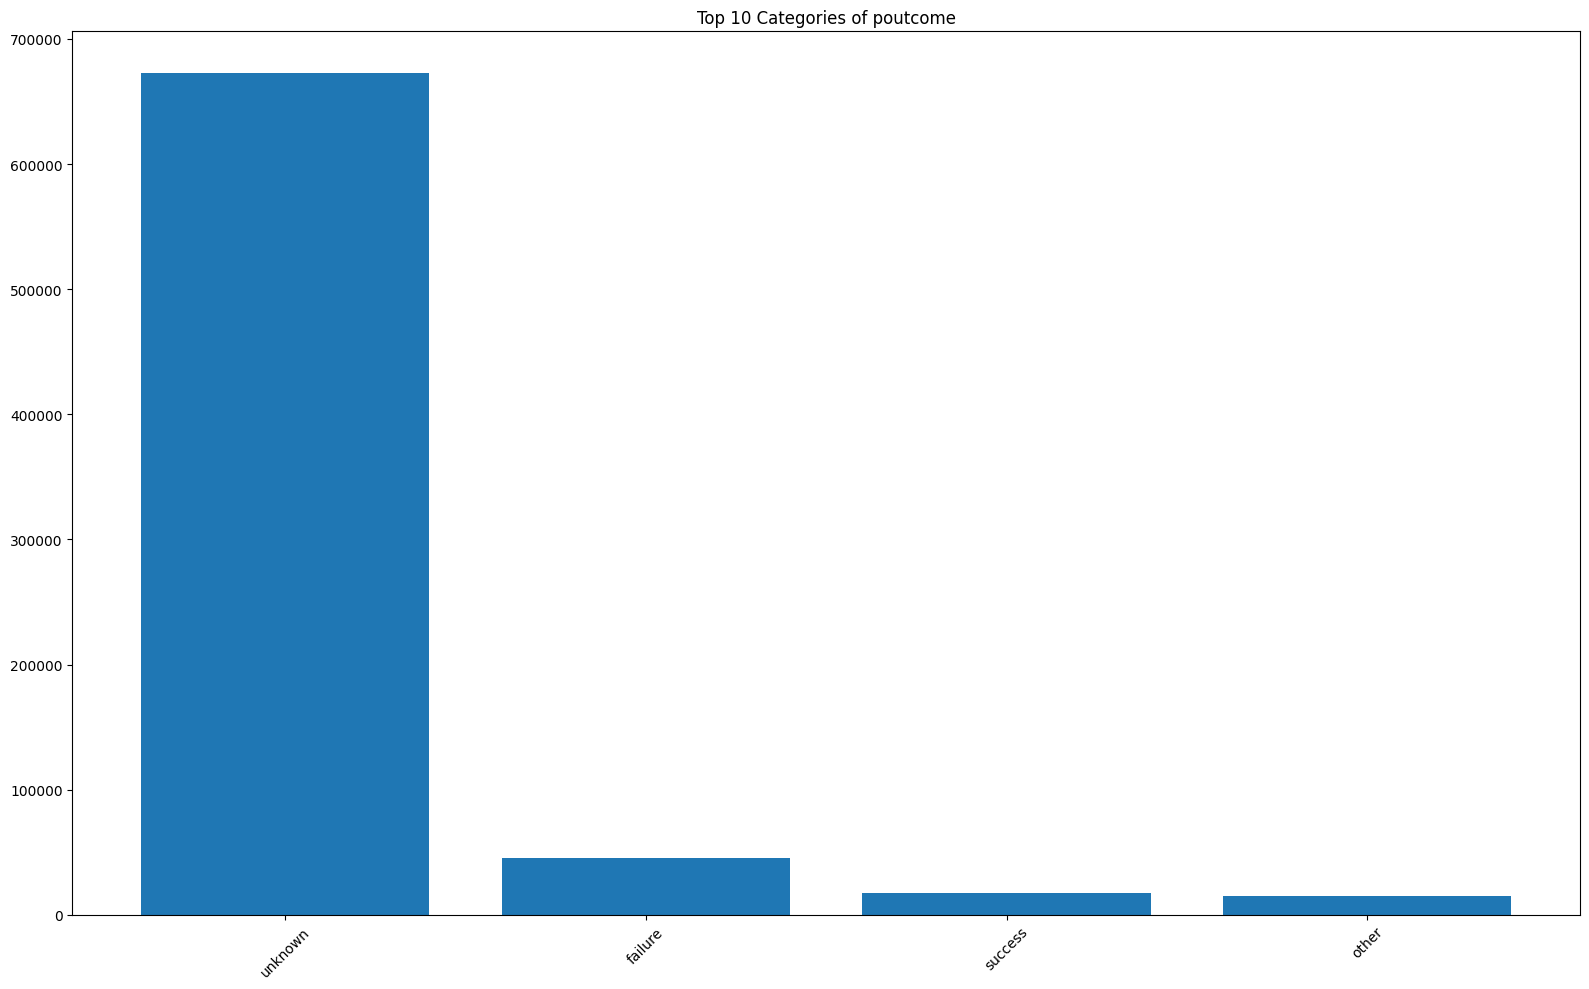

In [ ]:
for col in cat_cols:
    valueCounts = train[col].value_counts().head(10)  # Top 10 Categories only
    plt.figure(figsize=(16, 10))
    plt.bar(valueCounts.index.astype(str), valueCounts.values)
    plt.title(f"Top 10 Categories of {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

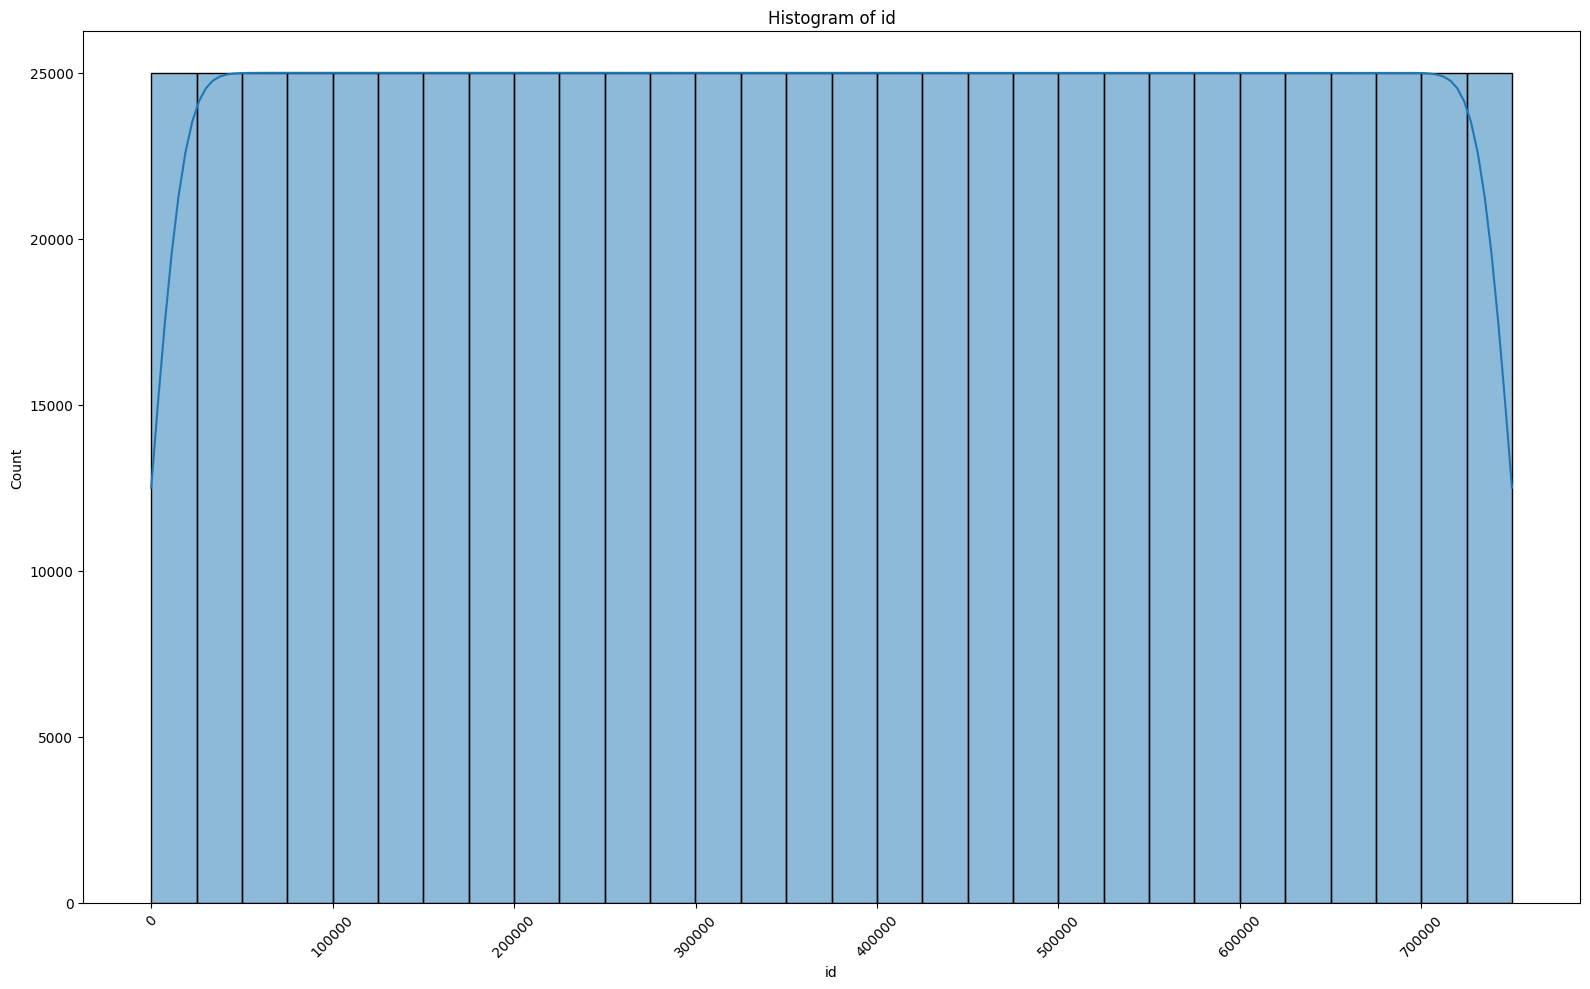

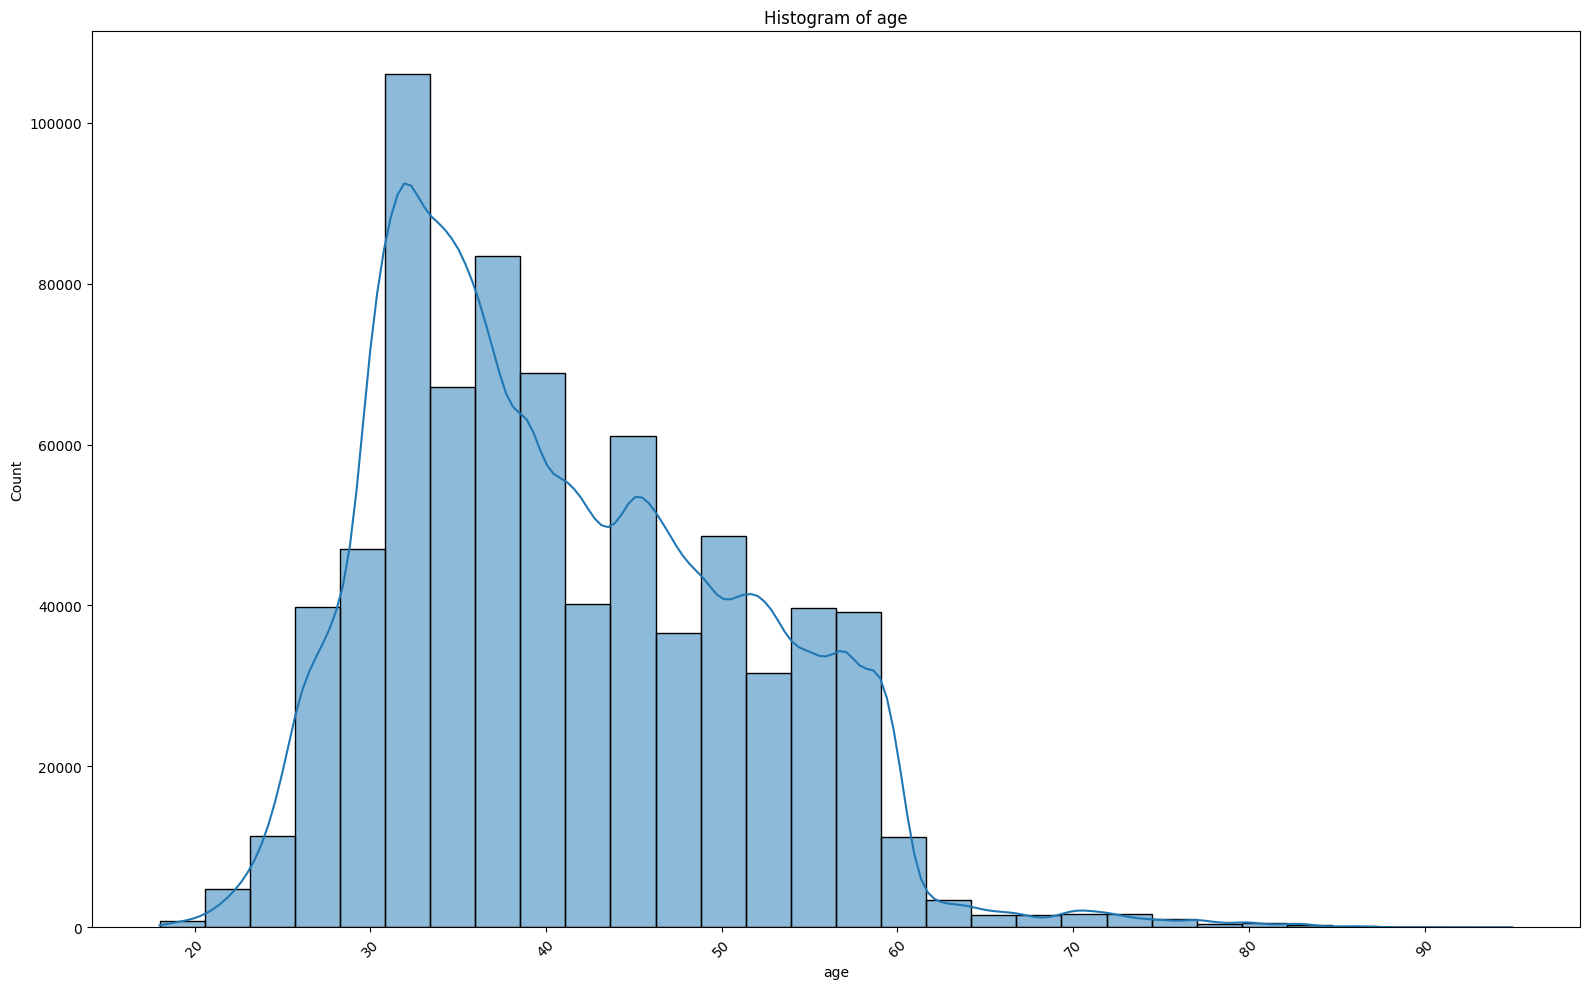

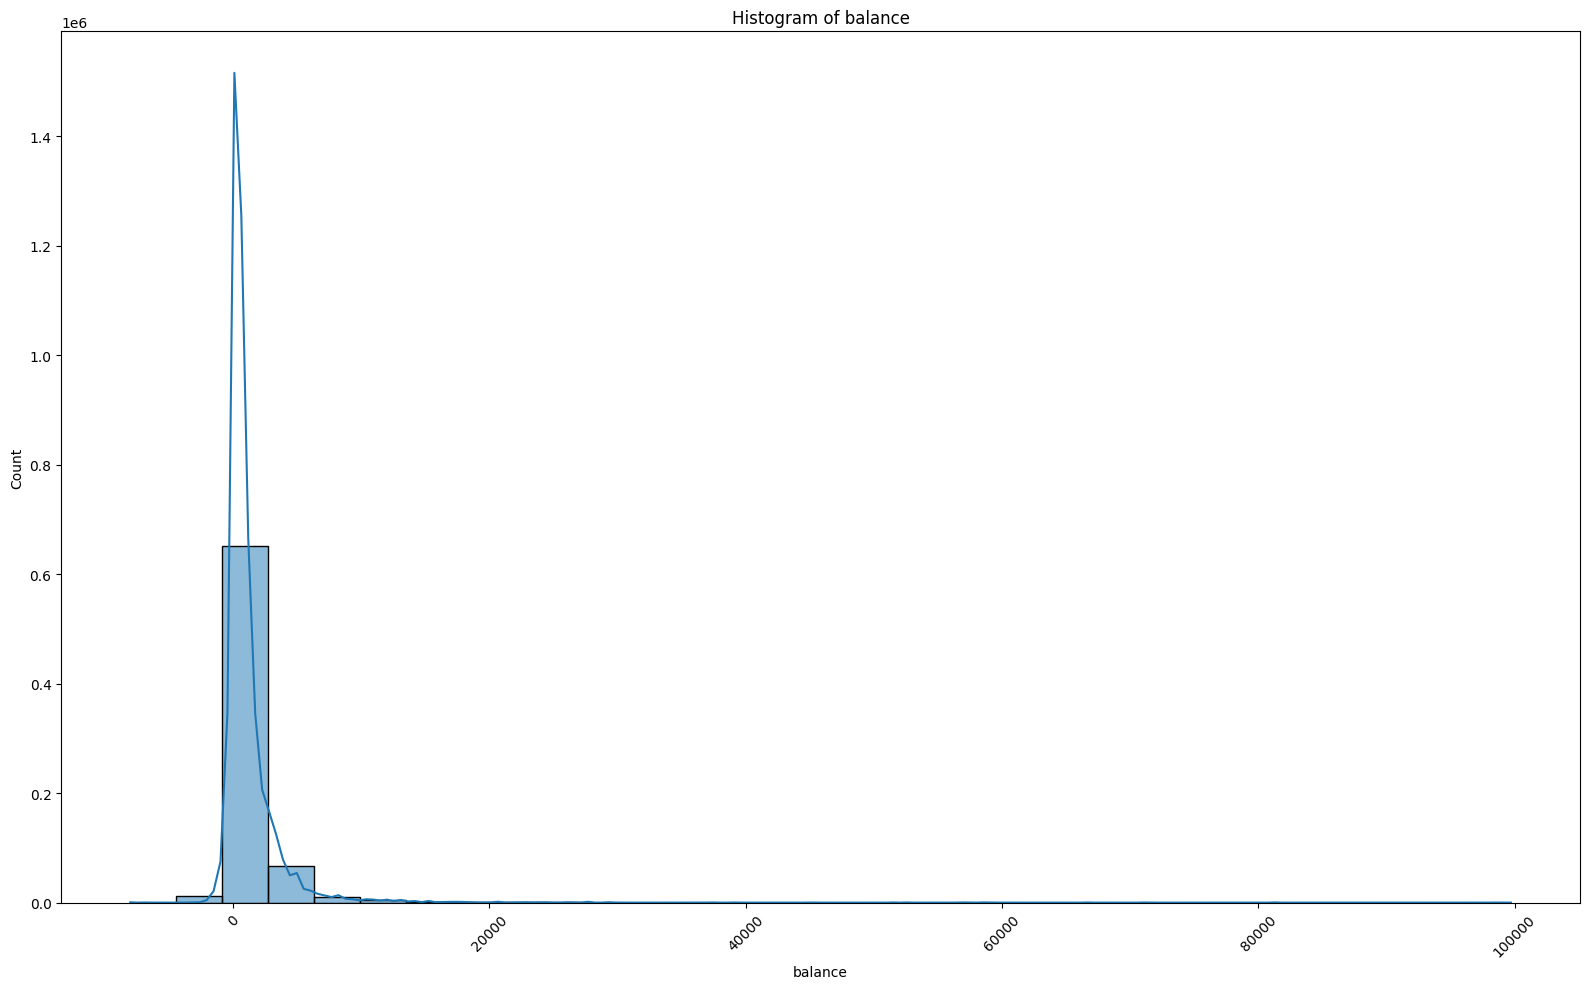

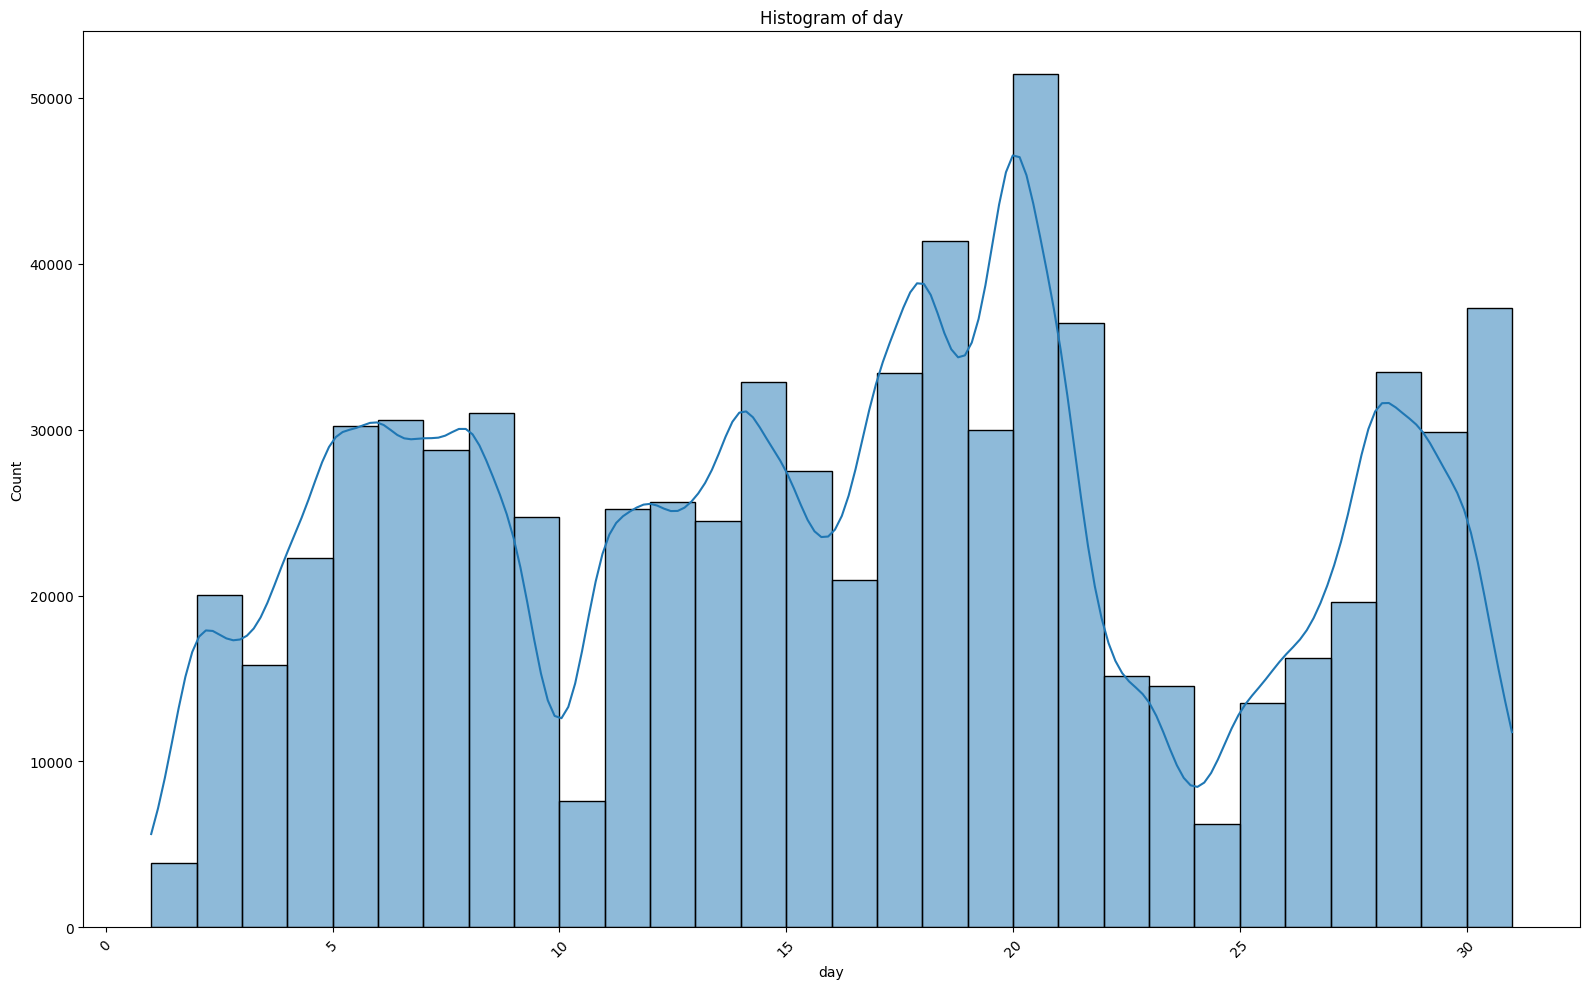

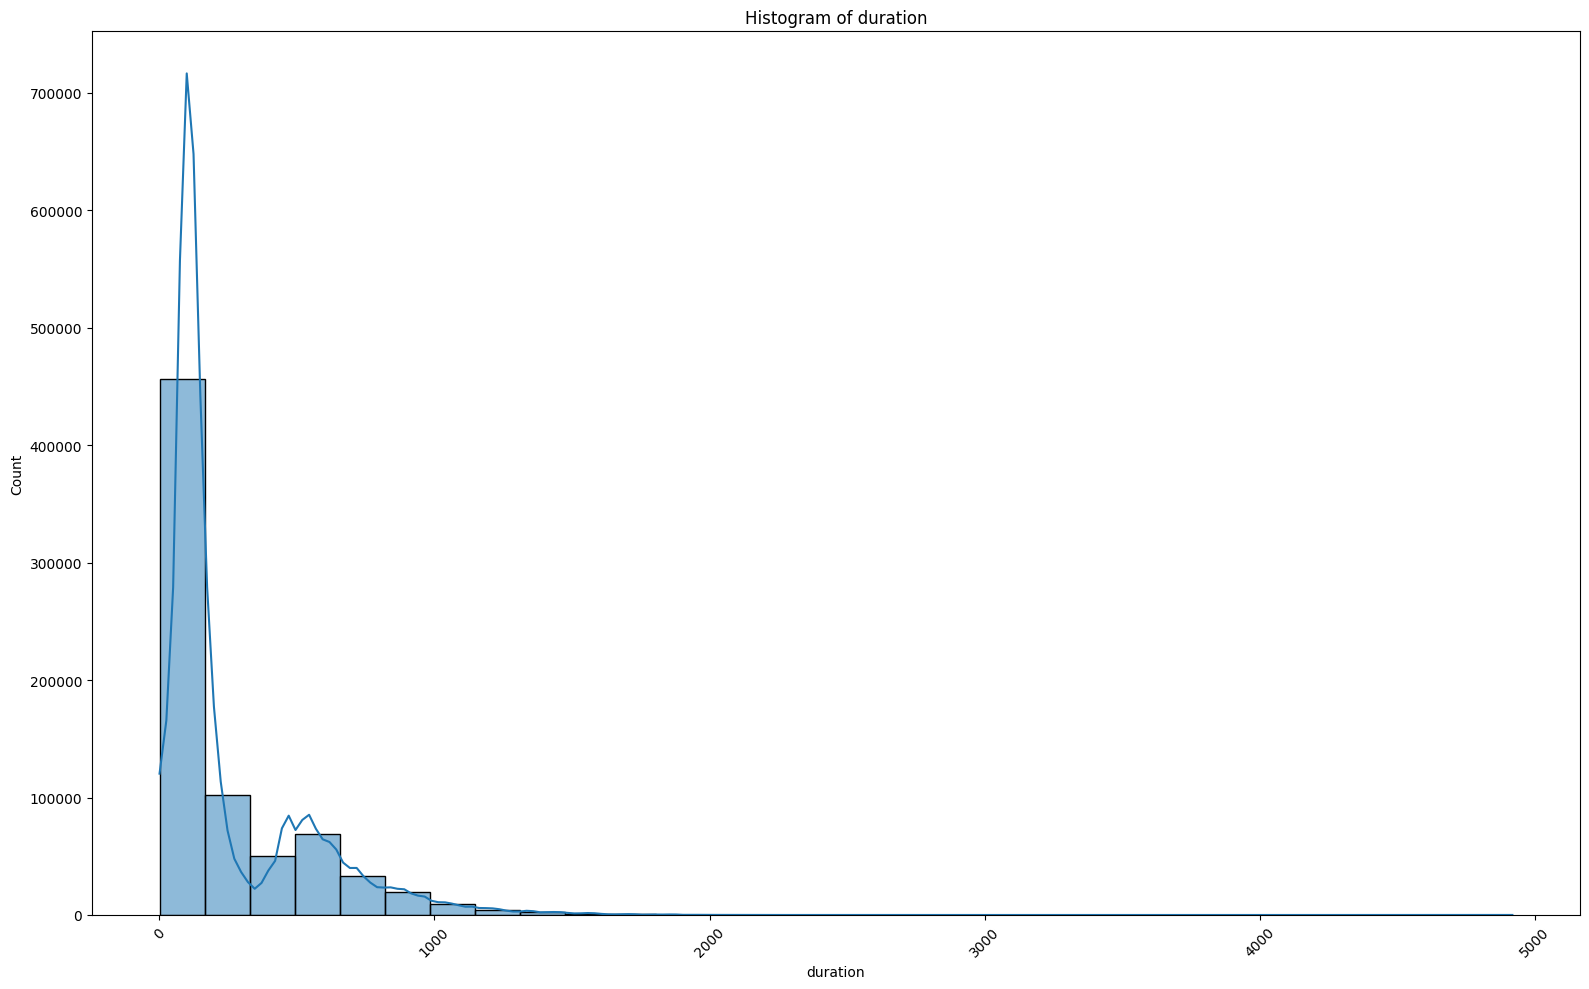

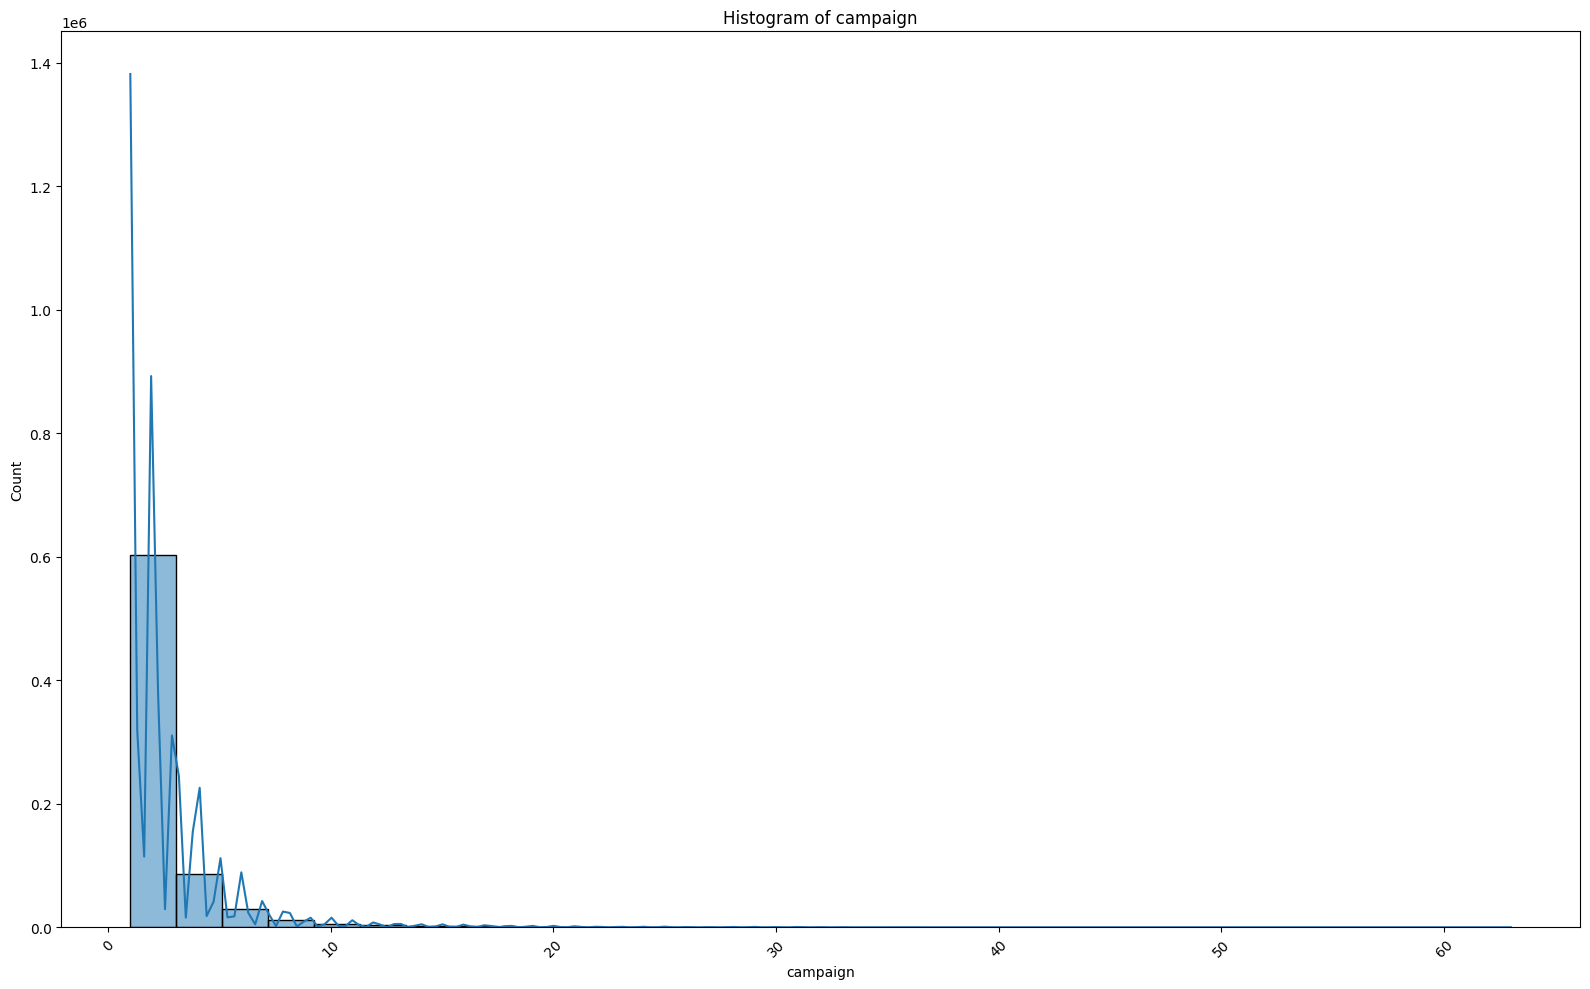

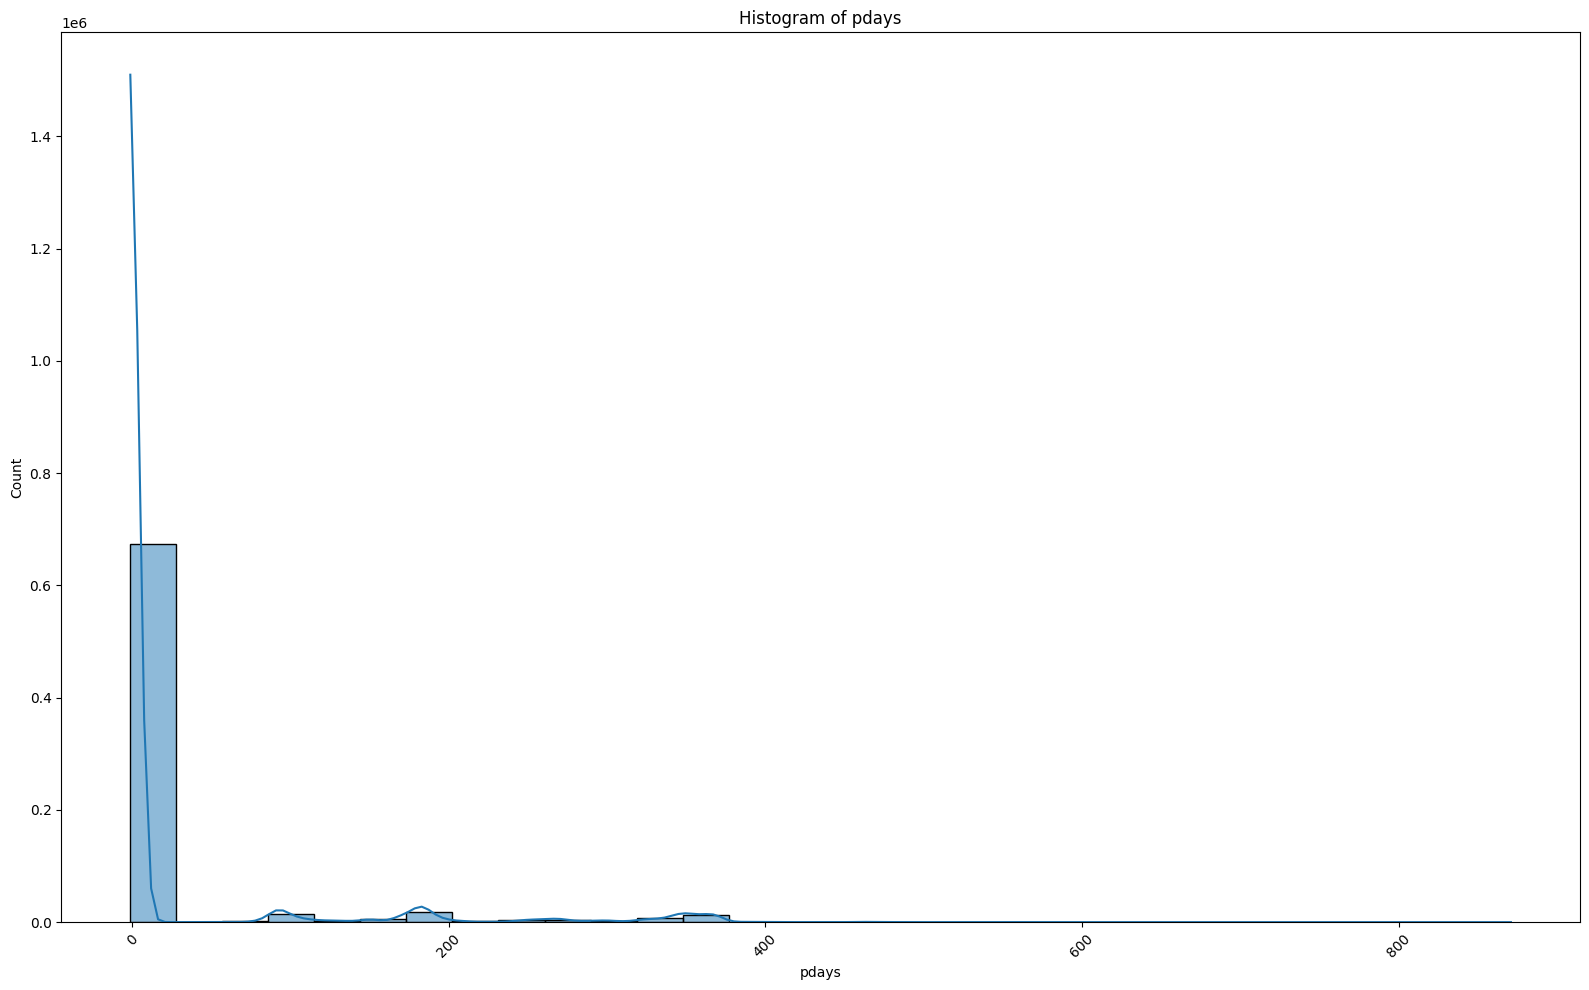

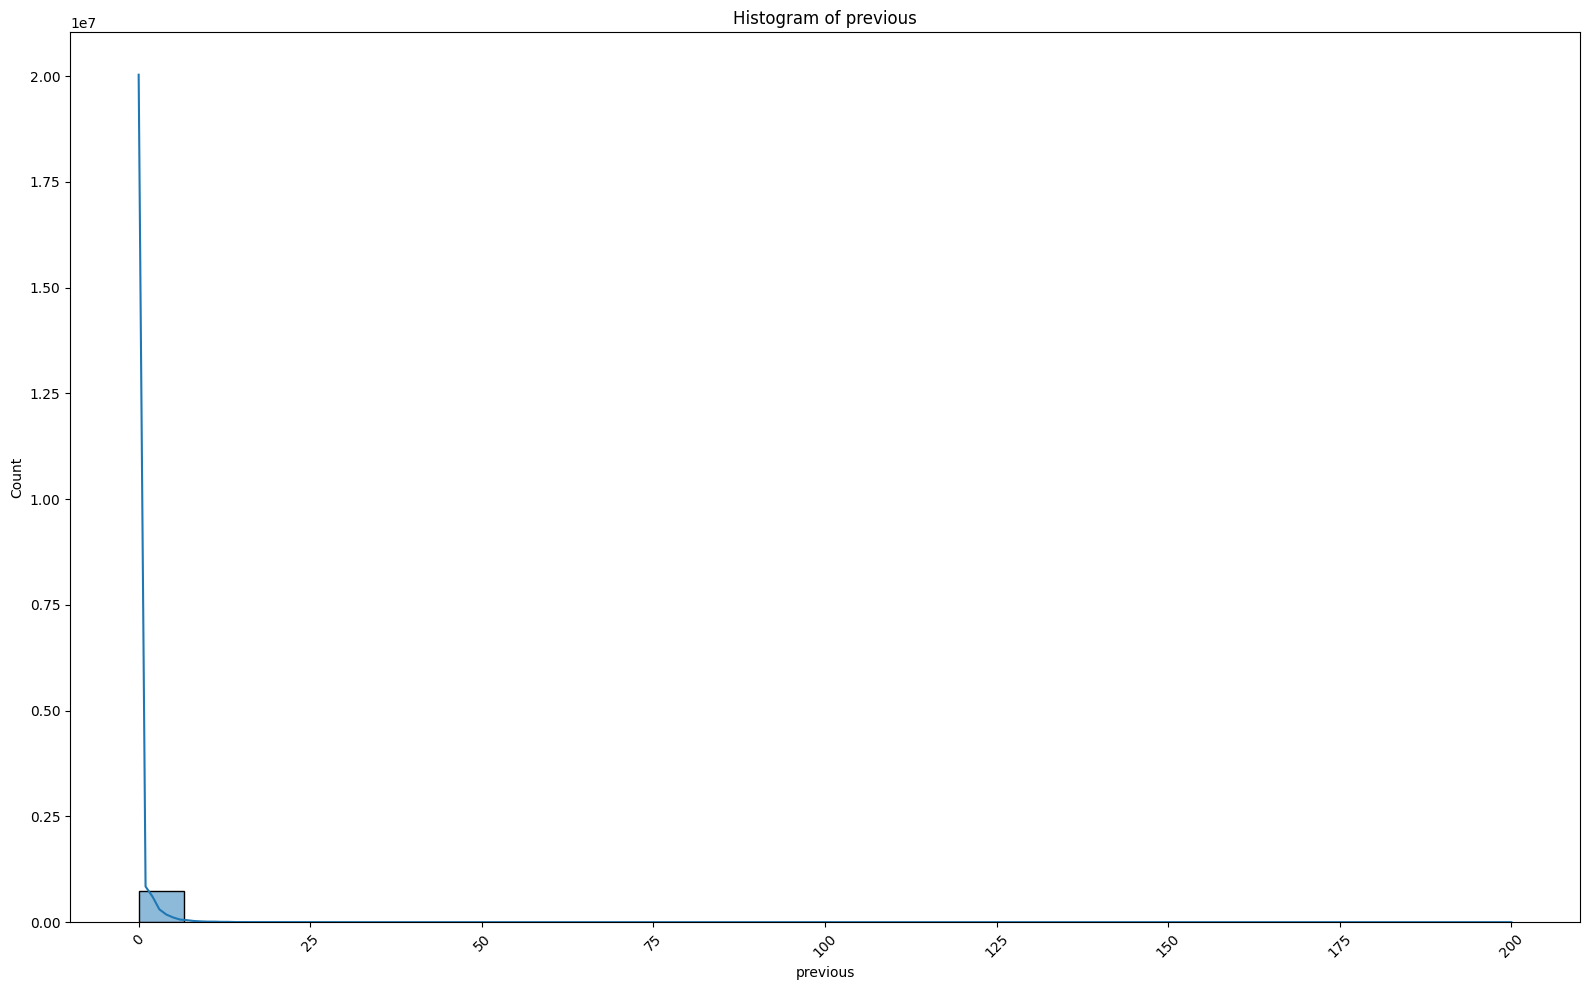

In [57]:
for col in num_cols:
    plt.figure(figsize=(16, 10))
    sns.histplot(x=col, data=train, kde=True, bins=30)
    plt.title(f"Histogram of {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Leakage Guard & Basic Feture Fixes

- Remove `duration` if present (classic leakage in bank marketing datasets).
- Convert `month` to an ordered integer if present.
- Handle `pdays == -1` as "Not contacted"


In [58]:
# Drop duration
leak_cols = [c for c in X.columns if c.lower() == 'duration']
if leak_cols:
    print("Dropping Potential Leakage:", leak_cols)
    X = X.drop(columns=leak_cols, axis=1)
    X_test = X_test.drop(columns=leak_cols, axis=1)

Dropping Potential Leakage: ['duration']


In [ ]:
# Order Month
month_map = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7,
             'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}

for df in [X, X_test]:
    if 'month' in df.columns and df['month'].dtype == object:
        df['month_num'] = df['month'].map(month_map).fillna(0).astype(int)

In [62]:
# Create flag='not_contracted' if pdays = -1
for df in [X, X_test]:
    if 'pdays' in df.columns:
        df["pdays_no_contract"] = (df['pdays'] == -1).astype(int)

In [63]:
display(X.head())
display(X_test.head())

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,month_num,pdays_no_contract
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,3,-1,0,unknown,8,1
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,1,-1,0,unknown,6,1
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,2,-1,0,unknown,5,1
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,2,-1,0,unknown,5,1
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,1,-1,0,unknown,2,1


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,month_num,pdays_no_contract
0,750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,1,-1,0,unknown,5,1
1,750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,2,-1,0,unknown,4,1
2,750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,2,-1,0,unknown,5,1
3,750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,1,-1,0,unknown,5,1
4,750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,1,-1,0,unknown,7,1


In [64]:
# Update num_cols and cat_cols
num_cols = X.select_dtypes(include=[np.number]).columns.to_list()
cat_cols = [c for c in X.columns if c not in num_cols]

display(num_cols)
display(cat_cols)

print("Numeric columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))

['id',
 'age',
 'balance',
 'day',
 'campaign',
 'pdays',
 'previous',
 'month_num',
 'pdays_no_contract']

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

Numeric columns: 9
Categorical columns: 9


### Preprocessing & Model Building

- `Numeric: StandardScaler`
- `Categorical: OneHot (ignore unknown)`


In [65]:
numeric = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric, num_cols),
        ('cat', categorical, cat_cols)
    ]
)

In [ ]:
# Cross-Validation General Utility
def cv_fit_predict(pipe, X, y, x_test, n_splits=5, random_state=42, verbose_name='Model'):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True,
                          random_state=random_state)
    oof = np.zeros(len(X))
    test_pred = np.zeros(len(X_test))
    aucs = []

    for fold, (trn_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_tr, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[trn_idx], y.iloc[val_idx]

        pipe.fit(X_tr, y_tr)
        val_pred = pipe.predict_proba(X_val)[:, 1]
        oof[val_idx] = val_pred
        test_pred += pipe.predict_proba(X_test)[:, 1] / skf.get_n_splits()

        auc = roc_auc_score(y_val, val_pred)
        aucs.append(auc)
        print(f"[{verbose_name}] Fold {fold} AUC: {auc:.5f}")

    cv_auc = roc_auc_score(y, oof)
    print(
        f"[{verbose_name}] CV AUC: {cv_auc:.5f} | Folds: {[round(a,5) for a in aucs]}")
    return oof, test_pred, cv_auc

In [70]:
models = {}
oofs = {}
tests = {}
cv_scores = {}

#### Baseline Model 1 Building (Logistic Regression)


In [ ]:
log_reg = LogisticRegression(max_iter=2000, n_jobs=-1, class_weight='balanced')

pipe_lr = Pipeline(steps=[
    ("pre", preprocessor),
    ("clf", log_reg)
])

oof_lr, test_lr, auc_lr = cv_fit_predict(
    pipe_lr, X, y, X_test, n_splits=5, random_state=42, verbose_name="LogReg")
models['lr'] = pipe_lr
oofs['lr'] = oof_lr
tests['lr'] = test_lr
cv_scores['lr'] = auc_lr

[LogReg] Fold 1 AUC: 0.79012
[LogReg] Fold 2 AUC: 0.78468
[LogReg] Fold 3 AUC: 0.78889
[LogReg] Fold 4 AUC: 0.78491
[LogReg] Fold 5 AUC: 0.78470
[LogReg] CV AUC: 0.78665 | Folds: [0.79012, 0.78468, 0.78889, 0.78491, 0.7847]


#### Baseline Model 2 Building (XGBoost)


In [ ]:
xgb_params = dict(
    n_estimators=500, learning_rate=0.05,
    max_depth=6, subsample=0.8,
    colsample_bytree=0.8, reg_lambda=1.0,
    random_state=42, eval_metric='auc', tree_method='hist'
)

pipe_xgb = Pipeline(steps=[
    ("pre", preprocessor),
    ("clf", XGBClassifier(**xgb_params))
])

oof_xgb, test_xgb, auc_xgb = cv_fit_predict(
    pipe_xgb, X, y, X_test, n_splits=5, random_state=42, verbose_name="XGBoost")
models['xgb'] = pipe_xgb
oofs['xgb'] = oof_xgb
tests['xgb'] = test_xgb
cv_scores['xgb'] = auc_xgb

[XGBoost] Fold 1 AUC: 0.85561
[XGBoost] Fold 2 AUC: 0.85175
[XGBoost] Fold 3 AUC: 0.85263
[XGBoost] Fold 4 AUC: 0.85227
[XGBoost] Fold 5 AUC: 0.85138
[XGBoost] CV AUC: 0.85272 | Folds: [0.85561, 0.85175, 0.85263, 0.85227, 0.85138]


#### Baseline Model 3 Building (LightGBM)


In [ ]:
lgbm_params = dict(
    n_estimators=1500,
    learning_rate=0.03,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight=None
)
pipe_lgb = Pipeline(steps=[('pre', preprocessor),
                    ('clf', LGBMClassifier(**lgbm_params))])
oof_lgb, test_lgb, auc_lgb = cv_fit_predict(
    pipe_lgb, X, y, X_test, n_splits=5, random_state=42, verbose_name="LightGBM")

models['lgb'] = pipe_lgb
oofs['lgb'] = oof_lgb
tests['lgb'] = test_lgb
cv_scores['lgb'] = auc_lgb

[LightGBM] [Info] Number of positive: 72391, number of negative: 527609
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120652 -> initscore=-1.986273
[LightGBM] [Info] Start training from score -1.986273
[LightGBM] Fold 1 AUC: 0.85686
[LightGBM] [Info] Number of positive: 72391, number of negative: 527609
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1061
[LightGBM] [Info] Number of data points in the train set: 600000, number of u

#### Baseline Model 4 Building (LightGBM)


In [ ]:
cat_params = dict(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    random_seed=42,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=False
)
pipe_cat = Pipeline(steps=[('pre', preprocessor),
                    ('clf', CatBoostClassifier(**cat_params))])
oof_cat, test_cat, auc_cat = cv_fit_predict(
    pipe_cat, X, y, X_test, n_splits=5, random_state=42, verbose_name="CatBoost")

models['cat'] = pipe_cat
oofs['cat'] = oof_cat
tests['cat'] = test_cat
cv_scores['cat'] = auc_cat

[CatBoost] Fold 1 AUC: 0.85039
[CatBoost] Fold 2 AUC: 0.84626
[CatBoost] Fold 3 AUC: 0.84812
[CatBoost] Fold 4 AUC: 0.84659
[CatBoost] Fold 5 AUC: 0.84549
[CatBoost] CV AUC: 0.84737 | Folds: [0.85039, 0.84626, 0.84812, 0.84659, 0.84549]


In [75]:
# Display Total CV Scores
print("CV scores:", cv_scores)

CV scores: {'lr': 0.7866524106398668, 'xgb': 0.8527214562663876, 'lgb': 0.8537799056147483, 'cat': 0.8473671726123585}


### Ensemble(Blending)

`Weighted average using CV AUC as weights.`


In [ ]:
available = {k: v for k, v in tests.items(
) if k in cv_scores and np.isfinite(cv_scores[k])}

weights = {k: cv_scores[k] for k in available.keys()}
w_sum = sum(weights.values())
weights = {k: v / w_sum for k, v in weights.items()}

print("Blend weights:", weights)

blend_test = np.zeros(len(X_test))
oof_blend = np.zeros(len(X))
for k in available.keys():
    blend_test += weights[k] * tests[k]
    oof_blend += weights[k] * oofs[k]

print("OOF Blend AUC:", roc_auc_score(y, oof_blend))

Blend weights: {'lr': 0.2354879444135507, 'xgb': 0.255266010982112, 'lgb': 0.25558286256476787, 'cat': 0.2536631820395695}
OOF Blend AUC: 0.8370062166965012


### Save Submission


In [77]:
sub_out = sub.copy()
pred_col = sub_out.columns[-1]
sub_out[pred_col] = blend_test

sub_path = "submission.csv"
sub_out.to_csv(sub_path, index=False)
print("Saved:", sub_path)
sub_out.head()

Saved: submission.csv


,id,y
0,750000,0.075327
1,750001,0.179037
2,750002,0.109812
3,750003,0.020137
4,750004,0.289831
